In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load cleaned data
df = pd.read_csv("D:/F ML Lab/Project/ML/processed/PROJECT_CLEANED_DATA.csv")


In [2]:
df.columns

Index(['primaryid', 'age', 'drug_count', 'indication_count', 'reaction_count',
       'all_reaction_pts', 'is_failure', 'rept_cod_5DAY', 'rept_cod_DIR',
       'rept_cod_EXP', 'rept_cod_PER', 'sex_I', 'sex_M', 'sex_P', 'sex_T',
       'sex_UNK', 'occp_cod_HP', 'occp_cod_LW', 'occp_cod_MD', 'occp_cod_OT',
       'occp_cod_PH', 'occp_cod_UNK', 'reporter_country_COUNTRY NOT SPECIFIED',
       'reporter_country_GB', 'reporter_country_OTHER', 'reporter_country_US'],
      dtype='object')

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
# Filter to failure reports only
failure_df = df[df['is_failure'] == 1]

# TF-IDF vectorization on reaction terms
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)
X_react = tfidf.fit_transform(failure_df['all_reaction_pts'].astype(str))


# Dimensionality Reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_react_reduced = svd.fit_transform(X_react)

n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
phenotype_labels = gmm.fit_predict(X_react_reduced)

failure_df['Failure_Phenotype'] = phenotype_labels

score = silhouette_score(X_react_reduced, phenotype_labels)
print(f"Silhouette Score for GMM clustering: {score:.4f}")

# Examine clusters for dominant terms
for i in range(n_clusters):
    cluster_indices = np.where(phenotype_labels == i)[0]
    print(f"\nPhenotype {i} sample reactions:")
    print(failure_df.iloc[cluster_indices]['all_reaction_pts'].head())


C:\Users\RAM PRAHASITH\AppData\Local\Temp\ipykernel_31256\1141766584.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_df['Failure_Phenotype'] = phenotype_labels


Silhouette Score for GMM clustering: 0.1212

Phenotype 0 sample reactions:
4                                           SPONDYLITIS
6     BLOOD PRESSURE DECREASED DEPRESSED LEVEL OF CO...
16                                          PERITONITIS
17                                              SURGERY
24                           ANEURYSM COUGH PAIN STRESS
Name: all_reaction_pts, dtype: object

Phenotype 1 sample reactions:
3                                       HOSPITALISATION
12    BRONCHOPLEURAL FISTULA PNEUMOTHORAX CONDITION ...
13                       MALIGNANT NEOPLASM PROGRESSION
45                                            PNEUMONIA
48    HYPOAESTHESIA LUMBAR VERTEBRAL FRACTURE MOVEME...
Name: all_reaction_pts, dtype: object

Phenotype 2 sample reactions:
80     DEATH
107    DEATH
115    DEATH
178    DEATH
191    DEATH
Name: all_reaction_pts, dtype: object


In [5]:
failure_df.loc[:, 'Failure_Phenotype'] = phenotype_labels

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 9)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_react_reduced)
    score = silhouette_score(X_react_reduced, labels)
    scores.append(score)
    print(f"K = {k}, Silhouette Score = {score:.4f}")

best_k = K_range[scores.index(max(scores))]
print(f"Best K based on silhouette score: {best_k}")


K = 2, Silhouette Score = 0.0220
K = 3, Silhouette Score = 0.1212
K = 4, Silhouette Score = 0.1051
K = 5, Silhouette Score = 0.1018
K = 6, Silhouette Score = 0.1130
K = 7, Silhouette Score = 0.1023
K = 8, Silhouette Score = 0.1073
Best K based on silhouette score: 3


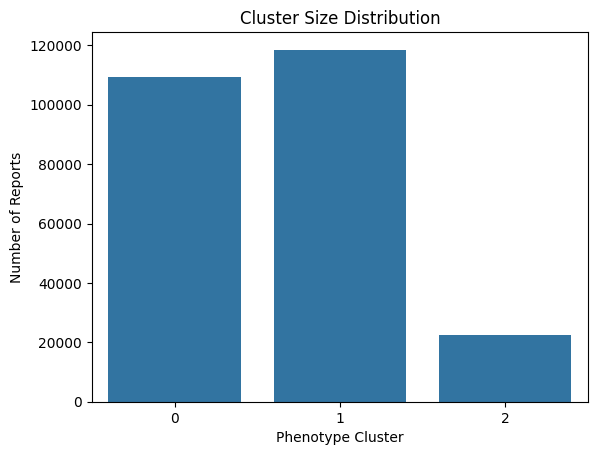

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=phenotype_labels)
plt.title("Cluster Size Distribution")
plt.xlabel("Phenotype Cluster")
plt.ylabel("Number of Reports")
plt.show()


In [7]:
# Assign cluster labels to failure_df
failure_df['Failure_Phenotype'] = phenotype_labels

# Drop existing cluster label column in master df, if exists, to avoid merge conflicts
if 'Failure_Phenotype' in df.columns:
    df = df.drop(columns=['Failure_Phenotype'])

# Merge phenotype labels back into master dataset
df = df.merge(
    failure_df[['primaryid', 'Failure_Phenotype']],
    on='primaryid',
    how='left'
)

# Fill missing phenotype labels for non-failure rows
df['Failure_Phenotype'] = df['Failure_Phenotype'].fillna(-1).astype(int)

print("Phenotype column added. Sample rows:")
print(df[['primaryid', 'Failure_Phenotype']].head())


C:\Users\RAM PRAHASITH\AppData\Local\Temp\ipykernel_31256\831704356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_df['Failure_Phenotype'] = phenotype_labels


Phenotype column added. Sample rows:
   primaryid  Failure_Phenotype
0  127337111                 -1
1  175404651                 -1
2  216513911                 -1
3  166753522                  1
4  150010251                  0


In [8]:
# Prepare data for supervised classification
clf_df = df[df['Failure_Phenotype'] != -1].copy().dropna(subset=['Failure_Phenotype'])

feature_cols = (
    ['age', 'drug_count', 'indication_count', 'reaction_count'] +
    [col for col in df.columns if col.startswith('sex_')] +
    [col for col in df.columns if col.startswith('occp_cod_')] +
    [col for col in df.columns if col.startswith('reporter_country_')]
)

X = clf_df[feature_cols]
y = clf_df['Failure_Phenotype'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 200193, Test size: 50049


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_mnb))


Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.44      0.46     21864
           1       0.61      0.43      0.50     23705
           2       0.25      0.72      0.37      4480

    accuracy                           0.46     50049
   macro avg       0.44      0.53      0.44     50049
weighted avg       0.52      0.46      0.47     50049



In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55     21864
           1       0.62      0.64      0.63     23705
           2       0.45      0.35      0.39      4480

    accuracy                           0.58     50049
   macro avg       0.54      0.51      0.53     50049
weighted avg       0.57      0.58      0.57     50049



In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


c:\Users\RAM PRAHASITH\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:38:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.57      0.57     21864
           1       0.65      0.70      0.68     23705
           2       0.51      0.34      0.41      4480

    accuracy                           0.61     50049
   macro avg       0.58      0.54      0.55     50049
weighted avg       0.61      0.61      0.61     50049



In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 250, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='multi:softmax', num_class=len(set(y_train)))

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best estimator to predict test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\RAM PRAHASITH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RAM PRAHASITH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\RAM PRAHASITH\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\RAM PRAHASITH\

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.8}
Best cross-validation accuracy: 0.6138
              precision    recall  f1-score   support

           0       0.58      0.57      0.57     21864
           1       0.65      0.71      0.68     23705
           2       0.51      0.34      0.41      4480

    accuracy                           0.61     50049
   macro avg       0.58      0.54      0.55     50049
weighted avg       0.61      0.61      0.61     50049



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split training data further for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(
    X_train_sub,
    y_train_sub,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=True
)

y_pred = xgb.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))